In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [4]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

# Regression and Classification

Written by: [Matthew R. Carbone](https://www.bnl.gov/staff/mcarbone) | _Assistant Computational Scientist, Computational Science Initiative, Brookhaven National Laboratory_

In this tutorial, we're going to go over the fundamentals of regression and classification, which are the two most common types of supervised learning. We will also discuss some of the best practices in machine learning, such as a train-validation-testing split. In regression problems, the objective is to learn a _continuous_ output. In classification problems, the objective is to learn a _discrete_ output. Here are some examples:
- Predicting the cost of a house from its properties, such as square footage, number of bathrooms, etc. is a _regression_ problem.
- Whether or not an image is of a cat or dog is a _classification_ problem.
- Predicting the type of animal in an image is a _classification_ problem.

**Learning objectives:**
- Understand a variety of regression and classification algorithms.
- Start to explore some of the fundamental concepts in machine learning, such as splitting data, overfitting, etc.

Regression and classification problems can be solved via a variety of different methods (or _models_). In this tutorial, we're going to go over the following types of models, which will form the backbone of your understanding for e.g. neural networks, and other types of machine learning, later on.
- Linear regression
- Polynomial regression
- Logistic regression

There are numerous [other types of models](https://www.listendata.com/2018/03/regression-analysis.html#Linear-Regression) which we simply won't have the time to dive into, but paradigmatically, the objective of all of these models is the same. Given some input, predict some output.

## Ingredients for regression

There are a few "ingredients" to always consider when approaching a regression problem.
- Your available data ("dataset")
- Your choice of model ("model")
- How you choose to fit the model to the data ("optimizer")
- An indicator for how well your model fits the data ("loss function"/"metric"/"criterion")

We will discuss all of these components today.

## Other resources

- [Andrew Ng's flagship Coursera course on machine learning](https://www.coursera.org/specializations/machine-learning-introduction)
- [Intro to regression analysis](https://towardsdatascience.com/introduction-to-regression-analysis-9151d8ac14b3)
- [15 types of regression](https://www.listendata.com/2018/03/regression-analysis.html#Linear-Regression)
- [Gradient descent tutorial](https://machinelearningmind.com/2019/10/06/gradient-descent-introduction-and-implementation-in-python/)

# Linear regression and gradient descent

Let's begin with the simplest form of regression: that of fitting a line to data. We can recast this problem as learning a function $f(x) = y,$ where the form of $f$ is simply the familiar $f(x) = mx + b.$ Given a dataset $\{x_i, y_i\}$, we can "learn" the coefficients $m$ and $b$ that best model the data.

In [5]:
def linear_model(x, m, b):
    return m * x + b

In [6]:
def linear_data_with_noise(seed=123, scale=0.5, N=100, slope=2.4, y_intercept=0.8):
    np.random.seed(seed)
    x = np.linspace(-1, 1, N)
    y = linear_model(x, slope, y_intercept) + np.random.normal(scale=scale, size=(N,))
    return x, y

In [7]:
x, y = linear_data_with_noise()

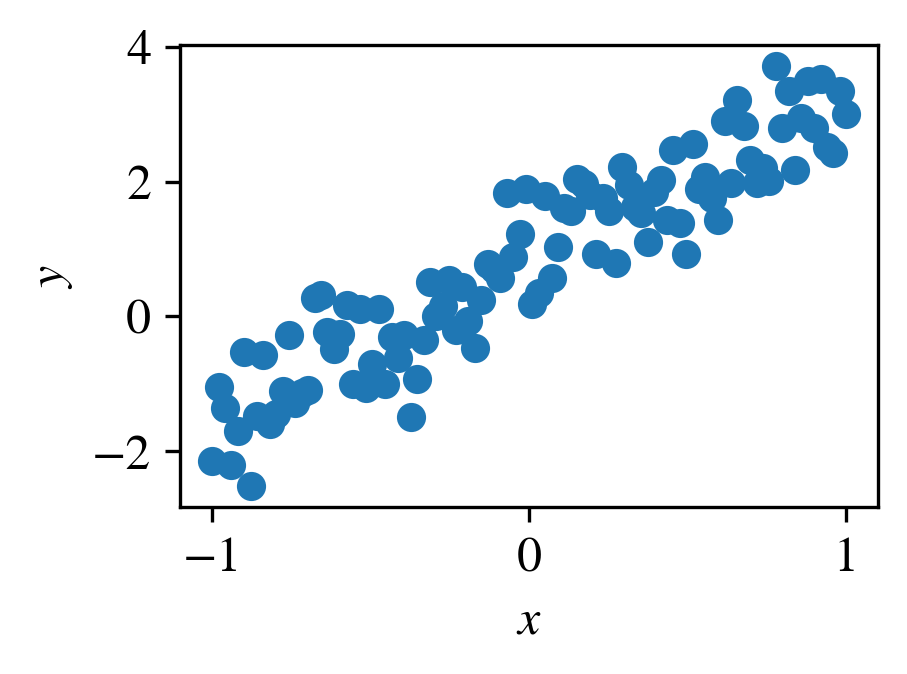

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.scatter(x, y)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.show()

Suppose we fix $m$ and $b$ to some values $m_0$ and $b_0$. We now have a model which is completely defined, and given some value for $x$, we can predict $y.$ But how do we know if these are good choices? We need to define a metric, or a measure of how well the model fits the data.

In [9]:
def criterion(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

Above, our `criterion` is called the average mean squared error. The square root of this is the "root-mean-squared" error, which you are likely familiar with. For the purposes of this example, it doesn't really matter.

## Evaluating an arbitrary model using a "random" optimizer

We know what the ground truth slope `m` and y-intercept `b` actually are, but let's pretend we don't, and evaluate a set of linear models against the data that we have. We can take a bunch of values for `m0` (guesses for the slope) and `b0` (guesses for the y-intercept), create a linear model with those parameters, and evaluate those against the actual data.

In [10]:
np.random.seed(123)
m0 = np.random.random(size=100) * 6 - 3  # 100 random numbers between -3 and 3
b0 = np.random.random(size=100)          # 100 random numbers between 0 and 1

Let's try every one of these combinations for `m0` and `b0`, and valuate the model against our data.

In [11]:
import pandas as pd
from itertools import product

In [12]:
m0b0 = list(product(m0, b0))

In [13]:
df = pd.DataFrame({
    "m0": [params[0] for params in m0b0],
    "b0": [params[1] for params in m0b0],
    "criterion": [criterion(y, linear_model(x, *params)) for params in m0b0]
})

In [14]:
df

,m0,b0,criterion
0,1.178815,0.513128,0.921456
1,1.178815,0.666625,0.852788
2,1.178815,0.105908,1.331962
3,1.178815,0.130895,1.297224
4,1.178815,0.321981,1.072844
...,...,...,...
9995,-0.939264,0.635900,4.157712
9996,-0.939264,0.032198,4.736670
9997,-0.939264,0.744781,4.130881
9998,-0.939264,0.472913,4.242188


In [15]:
argmin = df["criterion"].argmin()

In [16]:
df.iloc[argmin, :]

m0           2.360335
b0           0.814844
criterion    0.318958
Name: 3765, dtype: float64

## ⚠️ Check your understanding/Discussion

What happened here?

## A smarter optimizer: gradient descent

It stands to reason that just randomly guessing parameters is probably not the most effective way of finding the right guess. Can we do better? Absolutely! [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), and its family of related methods (you may have heard of [Adam](https://arxiv.org/abs/1412.6980)), can be used to find an optimal set of parameters for arbitrary models.

Gradient descent, and its related methods, are all about finding the optima of functions. For example, if I give you a function $f(x) = (x-2)^2$ and ask you to find its minimum, how would you do this. From calculus, you might know how. You also might recognize this is a simple parabola and know the answer right away. But what about some arbitrary function, possibly with many _local_ minima, and possibly a _huge_ number of parameters (in machine learning, this number can easily be greater than $10^7$)? Gradient descent is a method for finding minima numerically.

Given a function $f(x)$ and its derivative $\nabla f(x),$ the general rule of gradient descent is that to find a point closer to the actual minimum of $f,$ we follow its gradient:

$$x_{n+1} = x_n - \gamma \nabla f(x_n).$$

This is perhaps easiest to see through an example. Let's consider the function $f(x) = (x-2)^2,$ which of course has derivative $df(x)/dx = 2(x-2).$

In [18]:
def gradient_descent(x0, f_prime, gamma, N=100):
    """The gradient descent algorithm for a scalar function.
    
    Parameters
    ----------
    x0 : float
        The initial guess for the minimum.
    f_prime : callable
        The derivative of the function of interest.
    gamma : float
        Learning rate.
    N : int
        Number of iterations.
        
    Returns
    -------
    list
        A list of the values of x found during gradient descent.
    """
    
    res = [x0]
    for ii in range(N):
        x_n = res[-1]
        res.append(x_n - gamma * f_prime(x_n))
    return res

In [131]:
points = np.array(gradient_descent(
    x0=10.0,
    f_prime=lambda x: 2.0 * (x - 2.0),
    gamma=0.1,
    N=100
))

We of course know that the true minimum of this function is at $x=2,$ but lets plot how well the `gradient_descent` function finds this minimum.

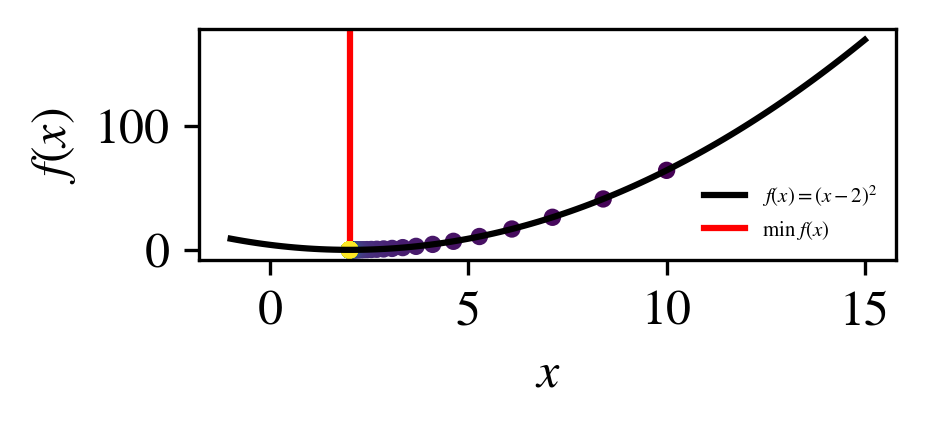

In [134]:
cmap = mpl.colormaps["viridis"].resampled(len(points))

fig, ax = plt.subplots(1, 1, figsize=(3, 1))

xgrid = np.linspace(-1, 15, 100)
ax.plot(xgrid, (xgrid - 2.0)**2, "k-", label=r"$f(x)=(x-2)^2$")
ax.scatter(points, (points - 2.0)**2, c=[cmap(ii) for ii in range(len(points))], s=10)
ax.axvline(2.0, zorder=-1, color="red", label="min $f(x)$")
ax.legend(frameon=False, fontsize=5)

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")

plt.show()

## ⚠️ Check your understanding/Discussion

Play around with the above code a bit. Here are some examples of things you can try.
- What happens if you make $\gamma$ really large?
- What happens if you make $\gamma$ really small?
- What happens if you change $x_0$?
- What happens if you change the function? For example, try $f(x) = \sin x$ (remember the derivative from calculus?). How sensitive is this procedure to your choice of $x_0$?

Here's a [video](https://upload.wikimedia.org/wikipedia/commons/transcoded/4/4c/Gradient_Descent_in_2D.webm/Gradient_Descent_in_2D.webm.720p.vp9.webm) of what gradient descent is doing with a lot of points. This arbitrary function is two dimensional. If you are not sure what's happening here, ask!

## Minimizing the loss function

Now we put two pieces together. As a reminder, the criterion, which we will now refer to as a loss function, is a measure of how different two data points are. We wish to minimize the average of this loss function when doing machine learning. 

For example, consider the linear fit from before. Our ground truth "training data" is $\{x_i, y_i\},$ and our model is simply $f(x; m, b) = mx + b$. We want to _minimize_ the difference between the ground truth values and predicted values on our dataset:

$$ L(m, b) = \sum_{i=1}^N (y_i - f(x_i; m, b))^2 $$

Specifically, we want to minimize $L$ with respect to $m$ and $b.$ Stated slightly differently, we want to find the corresponding values of $m, b$ such that $L$ is minimized. We just learned of a way to do this, gradient descent! However, to use gradient descent, we need the partial derivatives of $L$ with respect to all parameters of interest. Luckily, $L$ is differentiable analytically.

NOTE: ALL machine learning models trained with the family of gradient descent methods have to have analytically known derivatives. This includes neural networks!

The derivatives are:

$$ \frac{\partial L(m, b)}{\partial m} = 2\sum_{i=1}^N (y_i - f(x_i; m, b)) x_i$$

and

$$ \frac{\partial L(m, b)}{\partial b} = 2\sum_{i=1}^N y_i - f(x_i; m, b).$$

Following the rule from before, the update rules for $m$ and $b$ are:

$$ m_{n+1} = m_n - \gamma \frac{\partial L(m, b)}{\partial m}$$

and

$$ b_{n+1} = b_n - \gamma \frac{\partial L(m, b)}{\partial b}.$$

# Logistic Regression